# Imports and Utils

In [162]:
import os
import sys

# Build an absolute path from this notebook's parent directory
sim_module_path = os.path.abspath(os.path.join('..', 'sim_measures'))
cl_module_path  = os.path.abspath(os.path.join('..', 'clustering'))
sys.path.append(sim_module_path)
sys.path.append(cl_module_path)

import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
from mpl_toolkits import mplot3d
import random
import math
import time

import similarity
import clustering
import kmedoids
from kneed import KneeLocator
import traj_dist.distance as tdist

In [142]:
datasets = pd.read_csv("../data/datasets/metadata.csv",sep=";")
sample = datasets.iloc[5]
datasets

,dataset,file,edr_eps,lcss_eps,erp,k,k_or_eps,aggl,db_eps,spectral_k,bbox
0,ASL,ASL_trajectories.csv,0.005,0.0001,"[0,0,0.20]","[96,96,96,96,96,96,96]",k,"[96,96,96,96,96,96,96]","[0.050,0.06,2,0.3,3,0.010]","[96,96,96,96,96,96,96]","[0.4,0.4,0.4]"
1,CROSS,CROSS_trajectories.csv,5.000,0.0050,"[200,250]","[19,19,19,19,19,19,19]",k,"[19,19,19,19,19,19,19]","[17.5,13,170,0.35,170,5]","[19,19,19,19,19,19,19]","[300,300]"
2,DigiLeTs,Digilets_sample_trajectories.csv,0.005,0.0001,"[0.5,0.5]","[62,62,62,62,62,62,62]",k,"[62,62,62,62,62,62,62]","[0.1,0.1,2.5,0.12,4,0.04]","[62,62,62,62,62,62,62]","[0.8,0.8]"
3,FishTrajectories,FT_trajectories.csv,1.000,0.0100,"[150,100]","[2,2,2,2,2,2,2]",k,"[2,2,2,2,2,2,2]","[20,20,250,0.12,500,5]","[2,2,2,2,2,2,2]","[200,100]"
4,Labomni,Labomni_trajectories.csv,1.000,0.0050,"[175,130]","[15,15,15,15,15,15,15]",k,"[15,15,15,15,15,15,15]","[15,15,1000,0.2,5000,5]","[15,15,15,15,15,15,15]","[200,160]"
5,Sample,sample.csv,0.005,0.0001,"[0.5,0.5]","[15,15,15,15,15,15,15]",k,"[15,15,15,15,15,15,15]","[0.1,0.1,2.5,0.12,4,0.04]","[15,15,15,15,15,15,15]","[0.8,0.8]"


# Hopkins Statistic

In [110]:
def create_random_trajectories(original_trajectories,n,bbox,is_3d=False):
    
    # sample n random trajectories
    trajs = random.sample(original_trajectories,n)

    random_trajectories = []
    # for each trajectory
    for t in trajs:

        curr_t = []    
        m = len(t)

        # choose random starting point
        p = [np.random.random() * bbox[0],np.random.random() * bbox[1]] if not is_3d else [np.random.random() * bbox[0],np.random.random() * bbox[1], np.random.random() * bbox[2]]
        curr_t.append(p)

        for i in range(m-1):

            # compute distance d (p_i,p_i+1)
            d = math.dist(t[i],t[i+1])
            
            # choose a random point with distance d from the previous point
            if not is_3d:
                theta = np.random.random() * 2 * math.pi
                x = curr_t[-1][0] + d * math.cos(theta)
                y = curr_t[-1][1] + d * math.sin(theta)
                curr_t.append([x,y])
            else:
                u1 = np.random.random()
                u2 = np.random.random()

                phi = math.acos(2 * u1 - 1) - 0.5 * math.pi
                lam = 2 * math.pi * u2

                x = d * math.cos(phi) * math.cos(lam)
                y = d * math.cos(phi) * math.sin(lam)
                z = d * math.sin(phi)
                curr_t.append([x,y,z])

        random_trajectories.append(np.array(curr_t))

    return random_trajectories

In [112]:
from sklearn.neighbors import NearestNeighbors

def hopkins_statistic(metadata):

    df = pd.read_csv(f"../data/datasets/{metadata["file"]}",sep=";")
    trajectories = df.apply(lambda x: np.array(json.loads(x["trajectory"])),axis=1).to_list()

    sample_size = int(0.05 * len(trajectories))    

    random_trajectories = create_random_trajectories(trajectories,sample_size,json.loads(metadata["bbox"]),metadata["dataset"] == "ASL")
    sample_trajectories = random.sample(trajectories,sample_size)    

    measures = ["discret_frechet", "hausdorff", "dtw", "edr", "erp", "sppd"] 
    m_scores = []
    for measure in measures:
        
        # compute distances
        if measure in ["discret_frechet","hausdorff","dtw","sspd"]:
            distances_x_x = tdist.cdist(sample_trajectories,sample_trajectories,metric=measure)
            distances_y_x = tdist.cdist(random_trajectories,sample_trajectories,metric=measure)
        
        elif measure == "edr":
            distances_x_x = tdist.cdist(sample_trajectories,sample_trajectories,metric=measure,eps=metadata["edr_eps"])
            distances_y_x = tdist.cdist(random_trajectories,sample_trajectories,metric=measure,eps=metadata["edr_eps"])

        elif measure == "erp":
            distances_x_x = tdist.cdist(sample_trajectories,sample_trajectories,metric=measure,g=np.array(json.loads(metadata["erp"]),np.float64))
            distances_y_x = tdist.cdist(random_trajectories,sample_trajectories,metric=measure,g=np.array(json.loads(metadata["erp"]),np.float64))

        # compute hopkins score
        w, _  = NearestNeighbors(n_neighbors=2,metric="precomputed").fit(distances_x_x).kneighbors(distances_x_x)
        u, _ = NearestNeighbors(n_neighbors=2,metric="precomputed").fit(distances_y_x).kneighbors(distances_y_x)
        w = [i[1] for i in w]
        u = [i[1] for i in u]        
        m_scores.append(sum(u)/(sum(u) + sum(w)))
        
    return    {"dataset" : metadata["dataset"],
                "dfr"   : m_scores[0],   
                "hd"    : m_scores[1],
                "dtw"   : m_scores[2],
                "edr"   : m_scores[3],
                "erp"   : m_scores[4],
                "sspd"  : m_scores[5]
              }


In [114]:
# Sample Computation
hopkins_statistic(sample)

100%|██████████| 3/3 [00:00<00:00, 750.01it/s]


{'dataset': 'Sample',
 'dfr': np.float64(0.7244811946705687),
 'hd': np.float64(0.8306116930023648),
 'dtw': np.float64(0.774895526889508),
 'edr': np.float64(0.522570217122425),
 'erp': np.float64(0.6790462206716958),
 'sspd': np.float64(0.6790462206716958)}

# Clustering

## DBSCAN - Parameter Estimation

In [122]:
from sklearn.neighbors import NearestNeighbors

def estimate_dbscan(data):    
    # load dataset
    df = pd.read_csv("../data/datasets/" + data["file"],sep=";")
    trajectories = df["trajectory"].apply(lambda x: np.array(json.loads(x)))

    min_pnts = 2 * len(trajectories[0][0]) + 1
    
    for measure in ["discrete_frechet","hausdorff","dtw","edr","erp","sspd"]:
        print(measure)
        
        # read distances from file
        with open(f"../data/similarities/{data["file"][:-4]}_{measure}.json") as f:
            distances = json.load(f)

        if measure == "lcss":
            distances = similarity.lcss_to_dist_matrix(distances)
        
        neighbors = NearestNeighbors(n_neighbors=min_pnts,metric='precomputed').fit(distances)
        dists, ind = neighbors.kneighbors()

        dists = np.sort(dists,axis=0)
        plt.plot(dists[:,1])
        plt.show()    

discrete_frechet


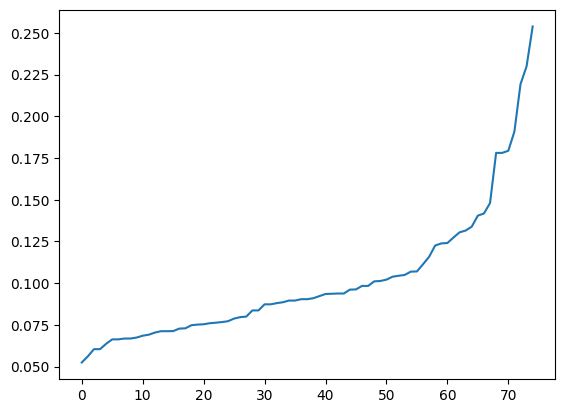

hausdorff


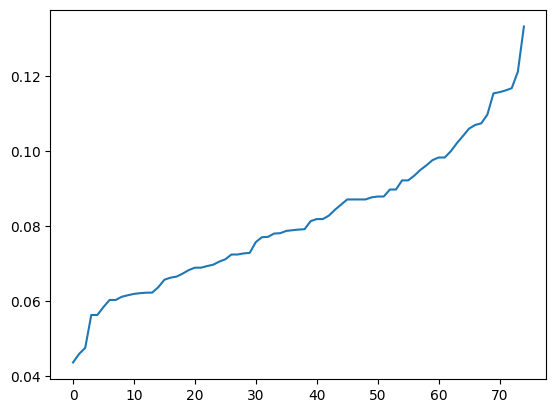

dtw


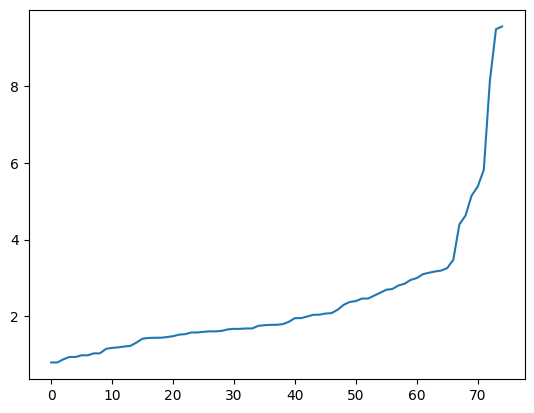

edr


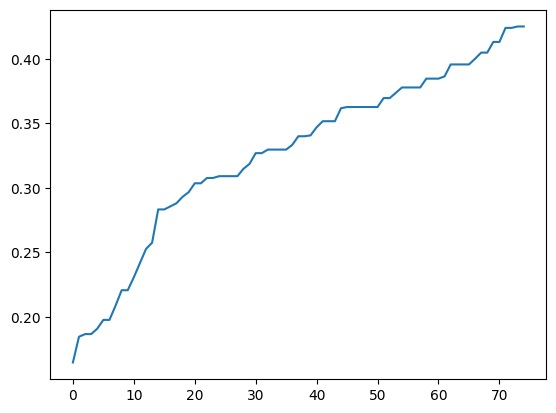

erp


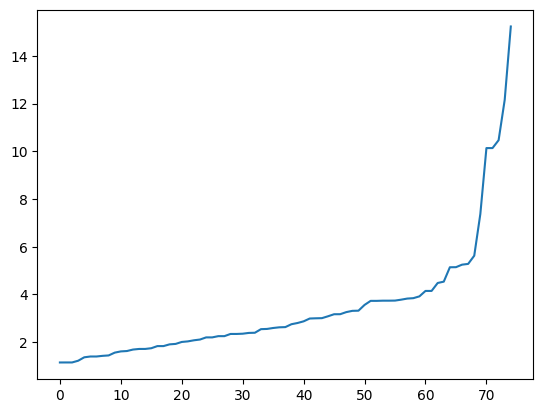

sspd


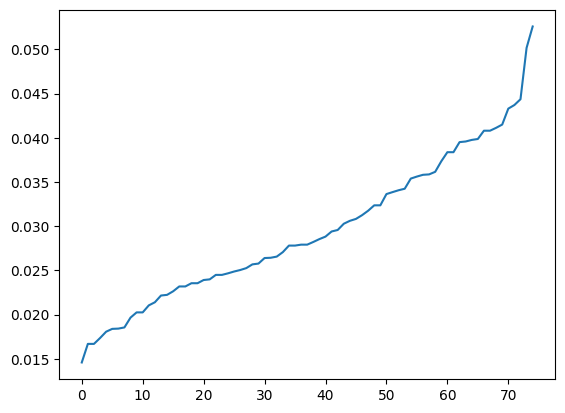

In [124]:
# Sample call
estimate_dbscan(sample)

You can decide the Eps-Parameter of DBSCAN either by visually or automatically (e.g. using the kneed package) finding the elbow point of these graphs.

##

In [173]:
measures = ["discrete_frechet","hausdorff","dtw","edr","erp","sspd"]

def run_experiments(data):

    print(data["dataset"])

    # Load trajectories and similarity values
    df = pd.read_csv("../data/datasets/" + data["file"],sep=";")
    trajectories = df["trajectory"].apply(lambda x: np.array(json.loads(x)))

    # set up needed parameters
    min_pnts = 2 * len(trajectories[0][0]) + 1

    # K Medoids
    km_labels = []
    km_time = []
    for i, measure in enumerate(measures):
        distances = []
        with open(f"../data/similarities/{data["file"][:-4]}_{measure}.json") as f:
            distances = json.load(f)
            
        if(not distances):
            continue

        t = time.perf_counter()
        km_labels.append(clustering.cluster(trajectories,distances,"k_medoids",nr_clusters=json.loads(data["k"])[i]))
        km_time.append(time.perf_counter() - t)
    
    # DBSCAN
    db_labels = []
    db_time   = []
    for i, measure in enumerate(measures):
        distances = []
        with open(f"../data/similarities/{data["file"][:-4]}_{measure}.json") as f:
            distances = json.load(f)

        if(not distances):
            continue

        t = time.perf_counter()
        db_labels.append(clustering.cluster(trajectories,distances,"dbscan",dbscan_eps=json.loads(data["db_eps"])[i]))
        db_time.append(time.perf_counter() - t)

    
    # HDBSCAN
    hdb_labels = []
    hdb_time   = []
    for i, measure in enumerate(measures):
        distances = []
        with open(f"../data/similarities/{data["file"][:-4]}_{measure}.json") as f:
            distances = json.load(f)

        if(not distances):
            continue

        t = time.perf_counter()
        hdb_labels.append(clustering.cluster(trajectories,distances,"hdbscan"))
        hdb_time.append(time.perf_counter() - t)

    # Agglomorative
    agg_labels = []
    agg_time   = []
    for i, measure in enumerate(measures):
        distances = []
        with open(f"../data/similarities/{data["file"][:-4]}_{measure}.json") as f:
            distances = json.load(f)

        if(not distances):
            continue

        t = time.perf_counter()
        if(data["k_or_eps"] == "k"):
            agg_labels.append(clustering.cluster(trajectories,distances,"agglomorative",nr_clusters=json.loads(data["aggl"])[i]))            
        else:
            agg_labels.append(clustering.cluster(trajectories,distances,"agglomorative",aggl_eps=json.loads(data["aggl"])[i]))
        agg_time.append(time.perf_counter() - t)

    # Spectral
    spc_labels = []
    spc_time   = []
    for i, measure in enumerate(measures):
        distances = []
        with open(f"../data/similarities/{data["file"][:-4]}_{measure}.json") as f:
            distances = json.load(f)

        if(not distances):
            continue

        t = time.perf_counter()
        spc_labels.append(clustering.cluster(trajectories,distances,"spectral_knn",nr_clusters=json.loads(data["spectral_k"])[i]))          
        spc_time.append(time.perf_counter() - t)

    # Build data frames
    d_list = []
    for i,_ in df.iterrows():
        curr = {
            "row_id" : i,
            "kmed_dfr" : km_labels[0][i],
            "kmed_hd"  : km_labels[1][i],
            "kmed_dtw" : km_labels[2][i],
            "kmed_edr" : km_labels[3][i],
            "kmed_erp" : km_labels[4][i],
            "kmed_sspd" : km_labels[5][i],
            "dbscan_dfr" : db_labels[0][i],
            "dbscan_hd"  : db_labels[1][i],
            "dbscan_dtw" : db_labels[2][i],
            "dbscan_edr" : db_labels[3][i],
            "dbscan_erp" : db_labels[4][i],
            "dbscan_sspd" : db_labels[5][i],
            "hdbscan_dfr" : hdb_labels[0][i],
            "hdbscan_hd"  : hdb_labels[1][i],
            "hdbscan_dtw" : hdb_labels[2][i],
            "hdbscan_edr" : hdb_labels[3][i],
            "hdbscan_erp" : hdb_labels[4][i],
            "hdbscan_sspd" : hdb_labels[5][i],
            "agglomorative_dfr" : agg_labels[0][i],
            "agglomorative_hd"  : agg_labels[1][i],
            "agglomorative_dtw" : agg_labels[2][i],
            "agglomorative_edr" : agg_labels[3][i],
            "agglomorative_erp" : agg_labels[4][i],
            "agglomorative_sspd" : agg_labels[5][i],
            "spectral_dfr" : spc_labels[0][i],
            "spectral_hd"  : spc_labels[1][i],
            "spectral_dtw" : spc_labels[2][i],
            "spectral_edr" : spc_labels[3][i],
            "spectral_erp" : spc_labels[4][i],
            "spectral_sspd" : spc_labels[5][i]
        }

        d_list.append(curr)


    runtime_dict = {
            "dataset" : data["dataset"],
            "kmed_dfr" : km_time[0],
            "kmed_hd"  : km_time[1],
            "kmed_dtw" : km_time[2],
            "kmed_edr" : km_time[3],
            "kmed_erp" : km_time[4],
            "kmed_sspd" : km_time[5],
            "dbscan_dfr" : db_time[0],
            "dbscan_hd"  : db_time[1],
            "dbscan_dtw" : db_time[2],
            "dbscan_edr" : db_time[3],
            "dbscan_erp" : db_time[4],
            "dbscan_sspd" : db_time[5],
            "hdbscan_dfr" : hdb_time[0],
            "hdbscan_hd"  : hdb_time[1],
            "hdbscan_dtw" : hdb_time[2],
            "hdbscan_edr" : hdb_time[3],
            "hdbscan_erp" : hdb_time[4],
            "hdbscan_sspd" : hdb_time[5],
            "agglomorative_dfr" : agg_time[0],
            "agglomorative_hd"  : agg_time[1],
            "agglomorative_dtw" : agg_time[2],
            "agglomorative_edr" : agg_time[3],
            "agglomorative_erp" : agg_time[4],
            "agglomorative_sspd" : agg_time[5],
            "spectral_dfr" : spc_time[0],
            "spectral_hd"  : spc_time[1],
            "spectral_dtw" : spc_time[2],
            "spectral_edr" : spc_time[3],
            "spectral_erp" : spc_time[4],
            "spectral_sspd" : spc_time[5]
        }
    
    pd.DataFrame(d_list).to_csv(f"../data/clustering_data/{data['file'][:-4]}_clustering.csv",sep=";",index=False)
    return runtime_dict


In [181]:
run_experiments(sample) # The resulting clustering is saved to a file
                        # Meanwhile the runtime is returned immediately as a dict

Sample


{'dataset': 'Sample',
 'kmed_dfr': 0.0004989998415112495,
 'kmed_hd': 0.0004276998806744814,
 'kmed_dtw': 0.00044260011054575443,
 'kmed_edr': 0.00041450001299381256,
 'kmed_erp': 0.00040609994903206825,
 'kmed_sspd': 0.00045020016841590405,
 'dbscan_dfr': 0.0011967001482844353,
 'dbscan_hd': 0.0009383000433444977,
 'dbscan_dtw': 0.00086240004748106,
 'dbscan_edr': 0.0008582000155001879,
 'dbscan_erp': 0.0010283999145030975,
 'dbscan_sspd': 0.0010556001216173172,
 'hdbscan_dfr': 0.0013541001826524734,
 'hdbscan_hd': 0.0010365000925958157,
 'hdbscan_dtw': 0.001097600208595395,
 'hdbscan_edr': 0.0008258000016212463,
 'hdbscan_erp': 0.0010323000606149435,
 'hdbscan_sspd': 0.0009503001347184181,
 'agglomorative_dfr': 0.0006562001071870327,
 'agglomorative_hd': 0.0006071000825613737,
 'agglomorative_dtw': 0.0005636999849230051,
 'agglomorative_edr': 0.000565800117328763,
 'agglomorative_erp': 0.0005671000108122826,
 'agglomorative_sspd': 0.0005712001584470272,
 'spectral_dfr': 0.03804020001

# Cluster Evaluation

In [206]:
from sklearn import metrics
def compute_metrics(dataset,method,measure,clusters,labels):

    adj_rand = metrics.adjusted_rand_score(labels,clusters)
    nmi      = metrics.normalized_mutual_info_score(labels,clusters)
    ami      = metrics.adjusted_mutual_info_score(labels,clusters)

    h        = metrics.homogeneity_score(labels,clusters)
    c        = metrics.completeness_score(labels,clusters)
    v1       = metrics.v_measure_score(labels,clusters)
    v2       = metrics.v_measure_score(labels,clusters,beta=2)   # more weight to c
    vp5      = metrics.v_measure_score(labels,clusters,beta=0.5)

    fmi      = metrics.fowlkes_mallows_score(labels,clusters)
    
    return {"setup" : f"{dataset}_{method}_{measure}", "adj_rand" : adj_rand, "nmi" : nmi, "ami" : ami, "homogeneity" : h, "completeness" : c, "v-1" : v1, "v-2" : v2, "v-0.5" : vp5, "fmi" : fmi}
    

In [220]:
# sample computation
sdf = pd.read_csv("../data/datasets/sample.csv",sep=";")
true_labels = sdf["symbol_id"].to_list()
comp_labels = pd.read_csv("../data/clustering_data/sample_clustering.csv",sep=";")

scores_df = []
abrvs = {"discrete_frechet" : "dfr", "hausdorff" : "hd", "dtw" : "dtw", "edr" : "edr", "erp" : "erp", "sspd" : "sspd"}
for method in ["kmed","dbscan","hdbscan", "agglomorative", "spectral"]:
    for measure in ["discrete_frechet","hausdorff","dtw","edr","erp","sspd"]:

        clustering = comp_labels[method + "_" + abrvs[measure]].tolist()
        scores_df.append(compute_metrics("Sample",method,measure,clustering,labels))

pd.DataFrame(scores_df).head()

,setup,adj_rand,nmi,ami,homogeneity,completeness,v-1,v-2,v-0.5,fmi
0,Sample_kmed_discrete_frechet,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000
1,Sample_kmed_hausdorff,0.649176,0.852531,0.729297,0.848110,0.856999,0.852531,0.854015,0.851053,0.669229
2,Sample_kmed_dtw,0.797399,0.941405,0.894292,0.925941,0.957394,0.941405,0.946675,0.936194,0.814211
3,Sample_kmed_edr,0.072253,0.415532,0.179676,0.321084,0.588700,0.415532,0.460705,0.378427,0.229763
4,Sample_kmed_erp,0.512187,0.840937,0.732503,0.787258,0.902473,0.840937,0.860495,0.822249,0.581641


# Correlation Analysis

In [261]:
def correlation_score(distances,labels):

    n = len(labels)

    min_d = min([min(l) for l in distances])
    max_d = max([max(l) for l in distances])
    norm = lambda x : (x - min_d)/(max_d - min_d)

    similarities = np.array([1 - norm(x) for l in distances for x in l ])
    cluster_matrix = np.array([labels[x] == labels[y] for x in range(n) for y in range(n)])

    return np.corrcoef(similarities, cluster_matrix)[0][1]

def compute_corr(dataset_name,file,ground_truth):

    cl_df = pd.read_csv(f"../data/clustering_data/{file}_clustering.csv",sep=";")

    measures = [[] for i in range(6)]
    
    for i,measure in enumerate(["discrete_frechet","hausdorff","dtw","edr","erp","sspd"]):

        with open(f"../data/similarities/{file}_{measure}.json") as read_file:
            distances = json.load(read_file)
        
        #distances = json.load("data/{dataset_name}_trajectories_{measure}.json")
        #distances = similarity.distance_matrix(trajectories,m)

        if measure == "discrete_frechet":
            measure = "dfr"
        if measure == "hausdorff":
            measure = "hd"
        
        for method in ["kmed","dbscan","hdbscan","agglomorative","spectral"]:
            labels = cl_df[f"{method}_{measure}"].to_list()
            measures[i].append(correlation_score(distances,labels))

        measures[i].append(correlation_score(distances,ground_truth))
    
    return {

        "dataset" : dataset_name,
        "dfr_kmed" : measures[0][0],
        "dfr_dbscan" : measures[0][1],
        "dfr_hdbscan" : measures[0][2],
        "dfr_agglomerative" : measures[0][3],
        "dfr_spectral" : measures[0][4],
        "dfr_gt"       : measures[0][5],
        "hd_kmed" : measures[1][0],
        "hd_dbscan" : measures[1][1],
        "hd_hdbscan" : measures[1][2],
        "hd_agglomerative" : measures[1][3],
        "hd_spectral" : measures[1][4],
        "hd_gt"       : measures[1][5],
        "dtw_kmed" : measures[2][0],
        "dtw_dbscan" : measures[2][1],
        "dtw_hdbscan" : measures[2][2],
        "dtw_agglomerative" : measures[2][3],
        "dtw_spectral" : measures[2][4],
        "dtw_gt" : measures[2][5],
        "edr_kmed" : measures[3][0],
        "edr_dbscan" : measures[3][1],
        "edr_hdbscan" : measures[3][2],
        "edr_agglomerative" : measures[3][3],
        "edr_spectral" : measures[3][4],
        "edr_gt"       : measures[3][5],
        "erp_kmed" : measures[4][0],
        "erp_dbscan" : measures[4][1],
        "erp_hdbscan" : measures[4][2],
        "erp_agglomerative" : measures[4][3],
        "erp_spectral" : measures[4][4],
        "erp_gt"       : measures[4][5],
        "sspd_kmed" : measures[5][0],
        "sspd_dbscan" : measures[5][1],
        "sspd_hdbscan" : measures[5][2],
        "sspd_agglomerative" : measures[5][3],
        "sspd_spectral" : measures[5][4],
        "sspd_gt": measures[5][5]
    }

In [265]:
# Sample computation
s_df = pd.read_csv("../data/datasets/sample.csv",sep=";")
pd.DataFrame([compute_corr("Sample","sample",s_df["symbol_id"].to_list())])

C:\Users\horro\anaconda3\envs\hiwi\Lib\site-packages\numpy\lib\_function_base_impl.py:3045: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
C:\Users\horro\anaconda3\envs\hiwi\Lib\site-packages\numpy\lib\_function_base_impl.py:3046: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]


,dataset,dfr_kmed,dfr_dbscan,dfr_hdbscan,dfr_agglomerative,dfr_spectral,dfr_gt,hd_kmed,hd_dbscan,hd_hdbscan,...,erp_hdbscan,erp_agglomerative,erp_spectral,erp_gt,sspd_kmed,sspd_dbscan,sspd_hdbscan,sspd_agglomerative,sspd_spectral,sspd_gt
0,Sample,0.510401,-0.114546,0.387886,0.526657,0.504426,0.510401,0.447972,0.380232,0.122156,...,0.69303,0.51444,0.283609,0.274479,0.392236,0.621275,0.136699,0.409676,0.388715,0.351891
